# MIE1624 Final Project

## part 1: Sentiment modeling

import libraries and read data

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
# import libraries
import pandas as pd
import matplotlib.pyplot as plt
import scipy
from scipy import stats
import random
import numpy as np
import re

from sklearn.model_selection import train_test_split

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
import xgboost as xgb
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.model_selection import GridSearchCV, KFold

import nltk
nltk.download('omw-1.4')

from nltk import word_tokenize
from nltk.stem import *
from nltk.corpus import stopwords

nltk.download("stopwords")
nltk.download("wordnet")
nltk.download('punkt')



[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [3]:
data = pd.read_csv("sentiment_analysis.csv")
data # label 0-negative; 1-positive

FileNotFoundError: ignored

### data-preprocessing

In [ ]:
def clean_text(text):
  # remove replied user tag 
  text = re.sub(r'RT @\w+: ', '',text)
  # remove html tag
  text = re.sub(r'http\S+', '', text)
  # remove hashtags appear in the end of the sentence
  text = re.sub(r'\s*#\w+\s*$', '', text)
  # remove hashtags symbols appear in the middle of the sentence
  text = re.sub("#|@", '', text).strip().lower() #strip the blankspace and turn characters into lowercases
  # remove emojis
  emoj = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
        u"\U00002500-\U00002BEF"  # chinese char
        u"\U00002702-\U000027B0"
        u"\U00002702-\U000027B0"
        u"\U000024C2-\U0001F251"
        u"\U0001f926-\U0001f937"
        u"\U00010000-\U0010ffff"
        u"\u2640-\u2642" 
        u"\u2600-\u2B55"
        u"\u200d"
        u"\u23cf"
        u"\u23e9"
        u"\u231a"
        u"\ufe0f"  # dingbats
        u"\u3030"
                      "]+", re.UNICODE)
  text = re.sub(emoj, '', text)

  # stopwords removal and apply lemmatizer
  stop_words = set(stopwords.words('english'))
  lemmatizer = WordNetLemmatizer()
  tokens = word_tokenize(text)

  updated_tokens = [lemmatizer.lemmatize(token) for token in tokens if token not in stop_words]

  new_text = ' '.join(updated_tokens)
  return new_text

In [ ]:
data["text"] = data["text"].apply(clean_text)
data.head()

,ID,text,label
0,7.680980e+17,josh jenkins looking forward tab breeder crown...,1
1,7.680980e+17,congratulation pakistan becoming no1testteam w...,1
2,7.680980e+17,"september , yesmag taking maine mendoza ’ surp...",1
3,7.680980e+17,"newly painted wall , thanks million custodial ...",1
4,7.680980e+17,excited announce : july 2017 feschotte lab rel...,1


### use tf-idf as feature engineering

TF * IDF = [ (Number of times term t appears in a document) / (Total number of terms in the document) ] * log10(Total number of documents / Number of documents with term t in it)

In [ ]:
target_data = data['label']
feature_data = data.drop(columns=['label'])

# split the data into training and testing dataset
X_train,X_test, y_train, y_test= train_test_split(feature_data, target_data, test_size=0.33, random_state=13)

In [ ]:
from imblearn.over_sampling import RandomOverSampler

ros = RandomOverSampler(random_state=13)

X_train, y_train = ros.fit_resample(X_train, y_train)

In [ ]:
# use tf-idf as feature engineering
vectorizer = TfidfVectorizer()
X_train_vec = vectorizer.fit_transform(X_train['text'])
X_test_vec = vectorizer.transform(X_test['text'])

In [ ]:
X_train_vec

<497466x221721 sparse matrix of type '<class 'numpy.float64'>'
	with 3436786 stored elements in Compressed Sparse Row format>

### Model Training

#### logistic regression 

In [ ]:
# find best hyperparameters using grid search and set 5 splits needed for cross-validation
parameters = {'C': [0.01,0.1,1,10],
              'solver':['newton-cg','liblinear','sag'],
              
                 }

lr = LogisticRegression()
gs_lr = GridSearchCV(lr, parameters, cv = 5)
gs_lr.fit(X_train_vec, y_train)

GridSearchCV(cv=5, estimator=LogisticRegression(),
             param_grid={'C': [0.01, 0.1, 1, 10],
                         'solver': ['newton-cg', 'liblinear', 'sag']})

In [ ]:
print("The best hyperparameters for linear regression are:", gs_lr.best_estimator_)

The best hyperparameters for linear regression are: LogisticRegression(C=10, solver='newton-cg')


In [ ]:
#set LogisticRegression(C=10, solver='liblinear')
best_lr = LogisticRegression(C=10, solver='liblinear')
best_lr.fit(X_train_vec, y_train)

LogisticRegression(C=10, solver='liblinear')

In [ ]:
# Predict the sentiment for the test data
y_pred_lr = best_lr.predict(X_test_vec)

In [ ]:
accuracy_lr = accuracy_score(y_test, y_pred_lr)
f1_lr = f1_score(y_test, y_pred_lr)
print('Accuracy of Logistic Regression is:', accuracy_lr)
print('f1_score of Logistic Regression is:', f1_lr)

Accuracy of Logistic Regression is: 0.9707537301106646
f1_score of Logistic Regression is: 0.9782087886843228


#### SVM

In [ ]:
best_svm = SVC(max_iter=2000)
best_svm.fit(X_train_vec, y_train)
y_pred_svm = best_svm.predict(X_test_vec)
accuracy_svm = accuracy_score(y_test, y_pred_svm)
f1_svm = f1_score(y_test, y_pred_svm)
print('Accuracy of SVM is:', accuracy_svm)
print('f1_score of SVM is:', f1_svm)

/usr/local/lib/python3.9/dist-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Accuracy of SVM is: 0.9060452568408303
f1_score of SVM is: 0.9275663744986099


#### Decision Trees:

In [ ]:

best_dt = DecisionTreeClassifier()
best_dt.fit(X_train_vec, y_train)
y_pred_dt = best_dt.predict(X_test_vec)
accuracy_dt = accuracy_score(y_test, y_pred_dt)
f1_dt = f1_score(y_test, y_pred_dt)
print('Accuracy of Decision Tree is:', accuracy_dt)
print('f1_score of Decision Tree is:', f1_dt)

Accuracy of Decision Tree is: 0.9466497825249133
f1_score of Decision Tree is: 0.9603210351746448


#### XGBoost

In [ ]:
parameters =    {
            'max_depth': [3, 5],
            'n_estimators': [50, 100],
            'colsample_bytree': [0.4, 0.8]
            }
xgb_model=xgb.XGBClassifier()
clf = GridSearchCV(xgb_model, parameters, cv = 5)
clf.fit(X_train_vec,y_train)
print("The best hyperparameters for XGBoost are:", clf.best_estimator_)

The best hyperparameters for XGBoost are: XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)


In [ ]:
best_xgb = xgb.XGBClassifier(colsample_bytree=0.8,max_depth=5,n_estimators=100)
best_xgb.fit(X_train_vec, y_train)
y_pred_xgb = best_xgb.predict(X_test_vec)
accuracy_xgb = accuracy_score(y_test, y_pred_xgb)
f1_xgb = f1_score(y_test, y_pred_xgb)
print('Accuracy of XGBoost is:', accuracy_xgb)
print('f1_score of XGBoost is:', f1_xgb)

Accuracy of XGBoost is: 0.9033529703242856
f1_score of XGBoost is: 0.9239941807097455


**After comparing the performance of all the 4 models, logistic regression is the best among these.**

## Part 2 Sentiment Classification

In [ ]:
#install vaderSentimentlibrary
!pip install vaderSentiment

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.0/126.0 KB 8.0 MB/s eta 0:00:00


In [ ]:
#import the library
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import seaborn as sns

### 2.1 Using Web-Scrapping Data from Twitter 
dataset: 3.15.2023-3.18.2023 English tweets about Russia's War in Ukraine <br>
BwandoWando. (2023). <i>🇺🇦 Ukraine Conflict Twitter Dataset</i> [Data set]. Kaggle. https://doi.org/10.34740/KAGGLE/DSV/5243632

2.1.1 Data Pre-Process

In [ ]:
df1 = pd.read_csv('20230315_UkraineCombinedTweetsDeduped.csv')
df2 = pd.read_csv('20230316_UkraineCombinedTweetsDeduped.csv')
df3 = pd.read_csv('20230317_UkraineCombinedTweetsDeduped.csv')
df4 = pd.read_csv('20230318_UkraineCombinedTweetsDeduped.csv')

df_twitter_p2 = pd.concat([df1, df2, df3, df4])
df_twitter_p2.head()

In [ ]:
df_twitter_p2.info()

In [ ]:
# read english tweets 
df_twitter_p2 = df_twitter_p2[['language', 'text', 'hashtags']]
df_twitter_p2 = df_twitter_p2[df_twitter_p2['language'].isin(['en'])].reset_index()

In [ ]:
df_twitter_p2["text"] = df_twitter_p2["text"].apply(clean_text)

In [ ]:
#Save the cleaned tweets as csv
#df_twitter_p2.to_csv('/content/cleaned_tweet_p2.csv', index = None, header=True)

To save time, you can skip the previous steps and start from here by reading the cleaned data

In [ ]:
cleaned_tweet_p2 = pd.read_csv('cleaned_tweet_p2.csv') #can use cleaned data directly to save time and comment out the followed line
#cleaned_tweet_p2 = df_twitter_p2.copy()
cleaned_tweet_p2.isnull().sum()

index        0
language     0
text        29
hashtags     0
dtype: int64

When save the cleaned data to .csv, got some missing values (29/412,197), it won't occur if read the raw data and clean it directly. We just drop the missing values if we read the cleaned data.

In [ ]:
#Drop missing values
cleaned_tweet_p2.dropna(inplace=True)

### 2.1.2 Apply our best-preformed trained sentiment model from Part 1

In [ ]:
X_tweet_p2_all = vectorizer.transform(cleaned_tweet_p2['text'])

In [ ]:
# apply the sentiment for the all tweet data
y_pred_tweet_p2_all = best_lr.predict(X_tweet_p2_all)
cleaned_tweet_p2['p1 best model label'] = y_pred_tweet_p2_all

In [ ]:
df_plot = cleaned_tweet_p2['p1 best model label'].value_counts(ascending = True).to_frame()
df_plot.rename(index ={0: 'Negative', 1: 'Positive'}, inplace = True)

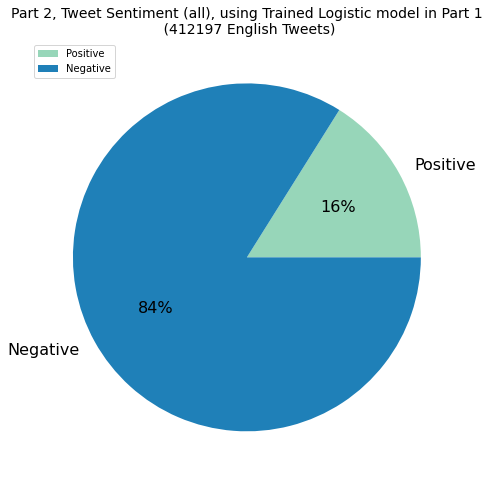

In [ ]:
color = sns.color_palette("YlGnBu", 2)

df_plot.plot(kind='pie', subplots=True, autopct='%.0f%%', figsize=(20, 8), fontsize=16, colors = color)
plt.title('Part 2, Tweet Sentiment (all), using Trained Logistic model in Part 1\n (%s English Tweets)'%len(cleaned_tweet_p2['p1 best model label']), fontsize = 14)
plt.ylabel('')
plt.legend(loc = 'upper left')

### 2.1.3 Apply pre-trained sentiment classification model VADER (Valence Aware Dictionary and Sentiment Reasoner) 

We choose VADER as it is a lexicon and rule-based sentiment analysis tool that is specifically designed to detect sentiments expressed in social media like twitter. <br>

We use VADER to filter out tweets with neutral sentiment

In [ ]:
def vader_sentiment(df):
  # Create a SentimentIntensityAnalyzer object.
  sid_obj = SentimentIntensityAnalyzer()
  def sentiment_vader(text):
    sentiment_dict = sid_obj.polarity_scores(text)

    if sentiment_dict['compound'] >= 0.05 :
        overall_sentiment = "Positive"

    elif sentiment_dict['compound'] <= - 0.05 :
        overall_sentiment = "Negative"

    else :
        overall_sentiment = "Neutral"
  
    return overall_sentiment
  df['VADER Sentiment'] = df['text'].apply(lambda x :sentiment_vader(x))

In [ ]:
def vader_label(df):
  # Create a SentimentIntensityAnalyzer object.
  sid_obj = SentimentIntensityAnalyzer()
  def sentiment_vader(text):
    sentiment_dict = sid_obj.polarity_scores(text)

    if sentiment_dict['compound'] >= 0.05 :
        overall_sentiment_label = "1"

    elif sentiment_dict['compound'] <= - 0.05 :
        overall_sentiment_label = "0"

    else :
        overall_sentiment_label = "0.5"
  
    return overall_sentiment_label
  df['VADER Label'] = df['text'].apply(lambda x :sentiment_vader(x))

In [ ]:
vader_sentiment(cleaned_tweet_p2)
vader_label(cleaned_tweet_p2)

In [ ]:
df_plot1 = cleaned_tweet_p2['VADER Sentiment'].value_counts(ascending = True).to_frame()

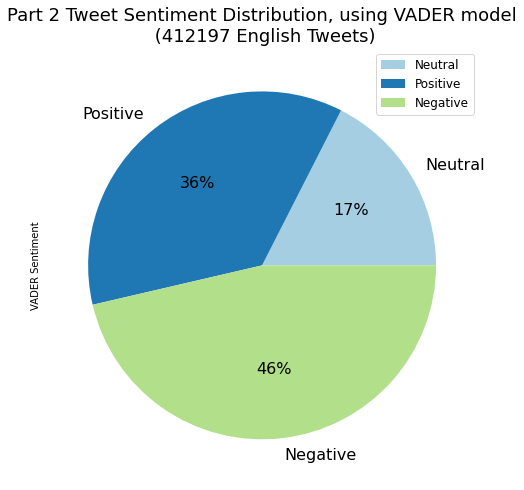

In [ ]:
color = sns.color_palette("Paired", 9)
df_plot1.plot(kind='pie', subplots=True, figsize=(20, 8), fontsize=16, autopct='%.0f%%', colors = color)
plt.title('Part 2 Tweet Sentiment Distribution, using VADER model\n (%s English Tweets)'%len(cleaned_tweet_p2['VADER Sentiment']), fontsize = 18)
plt.legend(loc = 'best',fontsize = 12)

In [ ]:
# drop neutral tweets
cleaned_tweet_useful = cleaned_tweet_p2[cleaned_tweet_p2['VADER Label'].isin(['0.5'])==False]

In [ ]:
cleaned_tweet_useful

,index,language,text,hashtags,p1 best model label,VADER Sentiment,VADER Label
0,1,en,"online class homework , assignment exam help e...","[{'text': 'USA', 'indices': [141, 145]}, {'tex...",0,Positive,1
1,2,en,british intelligence ukrainerussiawar map mar ...,"[{'text': 'UkraineRussiaWar', 'indices': [21, ...",0,Positive,1
2,4,en,learn love prosper video ! russianwarcrimes uk...,"[{'text': 'RussianWarCrimes', 'indices': [69, ...",1,Positive,1
3,5,en,usa -the pentagon plan increase spending cyber...,"[{'text': 'USA', 'indices': [0, 4]}, {'text': ...",0,Positive,1
5,7,en,russia ’ combat loss ukrainewar front includin...,"[{'text': 'UkraineWar', 'indices': [26, 37]}, ...",0,Negative,0
...,...,...,...,...,...,...,...
412220,184245,en,ukrainian child destined experience horror war...,"[{'text': 'Russia', 'indices': [107, 114]}, {'...",0,Negative,0
412221,184247,en,"ukrainian soldier bakhmut , house house fighti...","[{'text': 'Bakhmut', 'indices': [23, 31]}, {'t...",0,Negative,0
412222,184248,en,poland slovakia jointly transfer 33 mig-29 fig...,"[{'text': 'Poland', 'indices': [84, 91]}, {'te...",1,Positive,1
412223,184250,en,russia syria assad ukraine zelenskywarcriminal...,"[{'text': 'Russia', 'indices': [0, 7]}, {'text...",0,Negative,0


### 2.1.4 Compare the results of our trained model with VADER

As Vader model classify the sentiment into three classes, but our model only classify sentiment into two models, we decided to exclude the rows that's been classified as 'Neutral' by Vader so that we can now compare these two models with only two classes.

In [ ]:
X_tweet_p2 = vectorizer.transform(cleaned_tweet_useful['text'])

In [ ]:
# apply the sentiment for the non-neutral tweet data
y_pred_tweet_p2 = best_lr.predict(X_tweet_p2)
cleaned_tweet_useful['p1 best model label (vader non-neutral only)'] = y_pred_tweet_p2

Check if extracting neutral tweet will affect seniment labeling using part 1 model.

In [ ]:
(cleaned_tweet_useful['p1 best model label'] != cleaned_tweet_useful['p1 best model label (vader non-neutral only)']).sum()

0

In [ ]:
df_plot2 = cleaned_tweet_useful['VADER Label'].value_counts(ascending = True).to_frame()
df_plot3 = cleaned_tweet_useful['p1 best model label (vader non-neutral only)'].value_counts(ascending = True).to_frame()
df_plot2.rename(index ={'0': 'Negative', '1': 'Positive'}, inplace = True)
df_plot3.rename(index ={0: 'Negative', 1: 'Positive'}, inplace = True)

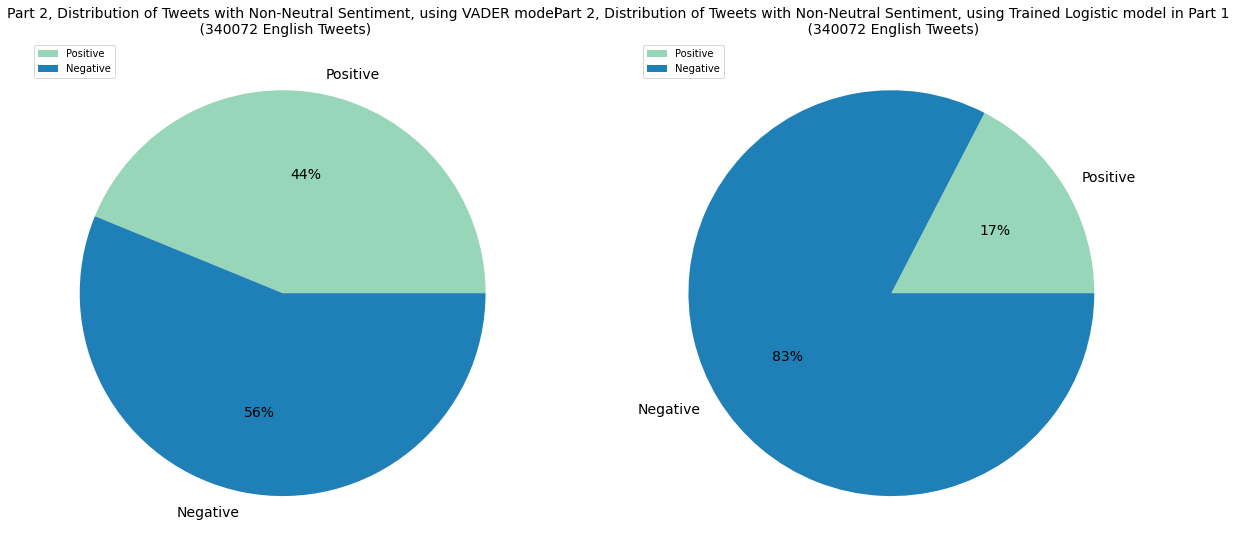

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 18))
color = sns.color_palette("YlGnBu", 2)


df_plot2.plot(kind='pie', subplots=True, autopct='%.0f%%', fontsize = 14, colors = color, ax=axes[0])
axes[0].set_title('Part 2, Distribution of Tweets with Non-Neutral Sentiment, using VADER model\n (%s English Tweets)'%len(cleaned_tweet_useful['VADER Sentiment']), fontsize = 14)
axes[0].set_ylabel('')
axes[0].legend(loc = 'upper left')

df_plot3.plot(kind='pie', subplots=True, autopct='%.0f%%', fontsize = 14, colors = color, ax=axes[1])
axes[1].set_title('Part 2, Distribution of Tweets with Non-Neutral Sentiment, using Trained Logistic model in Part 1\n (%s English Tweets)'%len(cleaned_tweet_useful['p1 best model label (vader non-neutral only)']), fontsize = 14)
axes[1].set_ylabel('')
axes[1].legend(loc = 'upper left')

plt.show()

In [ ]:
#cleaned_tweet_useful.to_csv('non-neutral tweets labeled using vader and lg.csv')
#cleaned_tweet_p2.to_csv('all tweets labeled using vader and lg.csv')

### 2.2 Using Ukraine Russia War Reddit Data
Download the dataset from https://www.kaggle.com/datasets/diyacharya/ukraine-russia-war-reddit-data

#### 2.2.1 Data Pre-Process

In [ ]:
reddit_raw = pd.read_csv('reddit_raw_ukraine_russia.csv')
reddit_raw.head()

,Unnamed: 0,comments,date,post_id,comment_id
0,0,"Hello /u/hjgbuijhgh,\n\nThis community is focu...",2022-06-27,vlvgj4,idxd71z
1,1,uhm thats quite the increase. \n\n\nI also he...,2022-06-27,vlvgj4,idxdtuz
2,2,Poland also announced that they plan to double...,2022-06-27,vlvgj4,idxit01
3,3,"Remember, NATO knows more than we’re being tol...",2022-06-27,vlvgj4,idxh1fc
4,4,"Well done, Putin. Top 2022 salesman of NATO. \...",2022-06-27,vlvgj4,idxhl5a


In [ ]:
reddit_raw.dropna(inplace=True)
reddit_raw.head()

,Unnamed: 0,comments,date,post_id,comment_id
0,0,"Hello /u/hjgbuijhgh,\n\nThis community is focu...",2022-06-27,vlvgj4,idxd71z
1,1,uhm thats quite the increase. \n\n\nI also he...,2022-06-27,vlvgj4,idxdtuz
2,2,Poland also announced that they plan to double...,2022-06-27,vlvgj4,idxit01
3,3,"Remember, NATO knows more than we’re being tol...",2022-06-27,vlvgj4,idxh1fc
4,4,"Well done, Putin. Top 2022 salesman of NATO. \...",2022-06-27,vlvgj4,idxhl5a


In [ ]:
reddit_df = reddit_raw["comments"].apply(clean_text)

reddit_df.to_csv('/content/cleaned_reddit_p2.csv', index = None, header=True)

# Focus on the comments column only
reddit_df = reddit_df.to_frame()

#### 2.2.2 Apply our best-preformed trained sentiment model from Part 1

In [ ]:
X_reddit = vectorizer.transform(reddit_df['comments'])

In [ ]:
# apply the sentiment for reddit data
y_pred_reddit = best_lr.predict(X_reddit)

In [ ]:
reddit_df['lr_predicted_label'] = y_pred_reddit

In [ ]:
reddit_df.head()

,comments,lr_predicted_label
0,"hello /u/hjgbuijhgh , community focused import...",1
1,uhm thats quite increase . also heared recentl...,0
2,poland also announced plan double armed force ...,0
3,"remember , nato know ’ told . ’ alarming amoun...",0
4,"well done , putin . top 2022 salesman nato . s...",0


In [ ]:
reddit_df.to_csv('/content/labeled_reddit_p2.csv', index = None, header=True)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
reddit_labels_plot = reddit_df['lr_predicted_label'].value_counts(ascending = True).to_frame()

reddit_labels_plot.rename(index ={0: 'Negative', 1: 'Positive'}, inplace = True)

<Axes: title={'center': 'Part 2, Reddit comments Sentiment (all), using Trained Logistic model in Part 1\n (16707 raddit comments)'}>

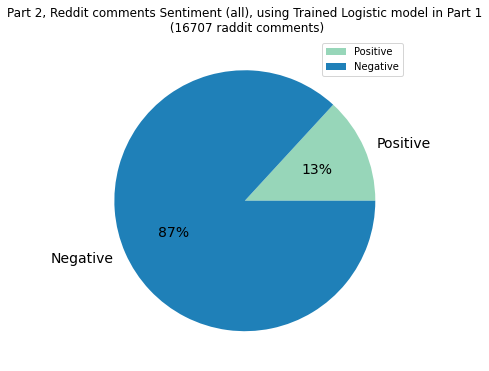

In [ ]:
color = sns.color_palette("YlGnBu", 2)

reddit_labels_plot.plot(kind='pie', y = 'lr_predicted_label', autopct='%.0f%%', fontsize = 14, colors = color, figsize=(11, 6),
              title = 'Part 2, Reddit comments Sentiment (all), using Trained Logistic model in Part 1\n (%s raddit comments)'% len(reddit_df['lr_predicted_label']), 
              ylabel='', )

#### 2.2.3 Apply pre-trained sentiment classification model VADER (Valence Aware Dictionary and Sentiment Reasoner) 

In [ ]:
sid = SentimentIntensityAnalyzer()
reddit_df['compound'] = reddit_df['comments'].apply(sid.polarity_scores).apply(lambda x : x['compound'])

In [ ]:
reddit_df.head()

,comments,lr_predicted_label,compound
0,"hello /u/hjgbuijhgh , community focused import...",1,0.9490
1,uhm thats quite increase . also heared recentl...,0,-0.0018
2,poland also announced plan double armed force ...,0,0.6908
3,"remember , nato know ’ told . ’ alarming amoun...",0,0.2500
4,"well done , putin . top 2022 salesman nato . s...",0,-0.9824


In [ ]:
THRESHOLD = 0.05

conditions = [
    (reddit_df['compound'] <= -THRESHOLD),
    (reddit_df['compound'] > -THRESHOLD) & (reddit_df['compound'] < THRESHOLD),
    (reddit_df['compound'] >= THRESHOLD)
]

values = ["neg", "neu", "pos"]
reddit_df['vadar_label'] = np.select(conditions, values)

In [ ]:
reddit_df.head()

,comments,lr_predicted_label,compound,vadar_label
0,"hello /u/hjgbuijhgh , community focused import...",1,0.9490,pos
1,uhm thats quite increase . also heared recentl...,0,-0.0018,neu
2,poland also announced plan double armed force ...,0,0.6908,pos
3,"remember , nato know ’ told . ’ alarming amoun...",0,0.2500,pos
4,"well done , putin . top 2022 salesman nato . s...",0,-0.9824,neg


In [ ]:
reddit_labels_plot_vadar = reddit_df['vadar_label'].value_counts(ascending = True).to_frame()

reddit_labels_plot_vadar.rename(index ={'neg': 'Negative', 'pos': 'Positive', 'neu':'Neutral'}, inplace = True)

<Axes: title={'center': 'Part 2, Reddit comments Sentiment (all), using Vader in Part 1\n (3 raddit comments)'}>

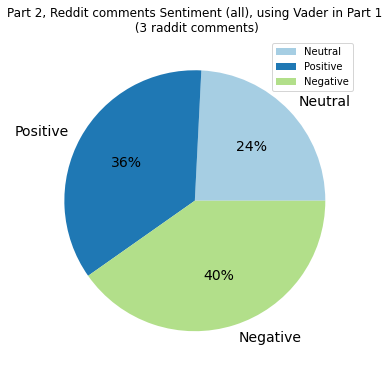

In [ ]:
color = sns.color_palette("Paired", 9)

reddit_labels_plot_vadar.plot(kind='pie', y = 'vadar_label', autopct='%.0f%%', fontsize = 14, colors = color, figsize=(11, 6),
              title = 'Part 2, Reddit comments Sentiment (all), using Vader\n (%s raddit comments)'% len(reddit_labels_plot_vadar['vadar_label']), 
              ylabel='')

#### 2.2.4 Compare the results of our trained model with VADER  
As Vader model classify the sentiment into three classes, but our model only classify sentiment into two models, we decided to exclude the rows that's been classified as 'Neutral' by Vader so that we can now compare these two models with only two classes.

In [ ]:
reddit_df_non_neu = reddit_df[reddit_df['vadar_label'] != 'neu']
reddit_df_non_neu = reddit_df_non_neu[['comments', 'vadar_label']]
reddit_df_non_neu.head()

,comments,vadar_label
0,"hello /u/hjgbuijhgh , community focused import...",pos
2,poland also announced plan double armed force ...,pos
3,"remember , nato know ’ told . ’ alarming amoun...",pos
4,"well done , putin . top 2022 salesman nato . s...",neg
5,good decision - russian incapable understandin...,pos


In [ ]:
X_reddit_non_neu = vectorizer.transform(reddit_df_non_neu['comments'])

In [ ]:
# apply the sentiment for reddit data
y_pred_reddit_non_neu = best_lr.predict(X_reddit_non_neu)

In [ ]:
reddit_df_non_neu['lr_predicted_label'] = y_pred_reddit_non_neu

In [ ]:
reddit_df_non_neu_plot = reddit_df_non_neu['lr_predicted_label'].value_counts(ascending = True).to_frame()
reddit_df_non_neu_plot_vader = reddit_df_non_neu['vadar_label'].value_counts(ascending = True).to_frame()

reddit_df_non_neu_plot.rename(index ={0: 'Negative', 1: 'Positive'}, inplace = True)
reddit_df_non_neu_plot_vader.rename(index ={'neg': 'Negative', 'pos': 'Positive'}, inplace = True)

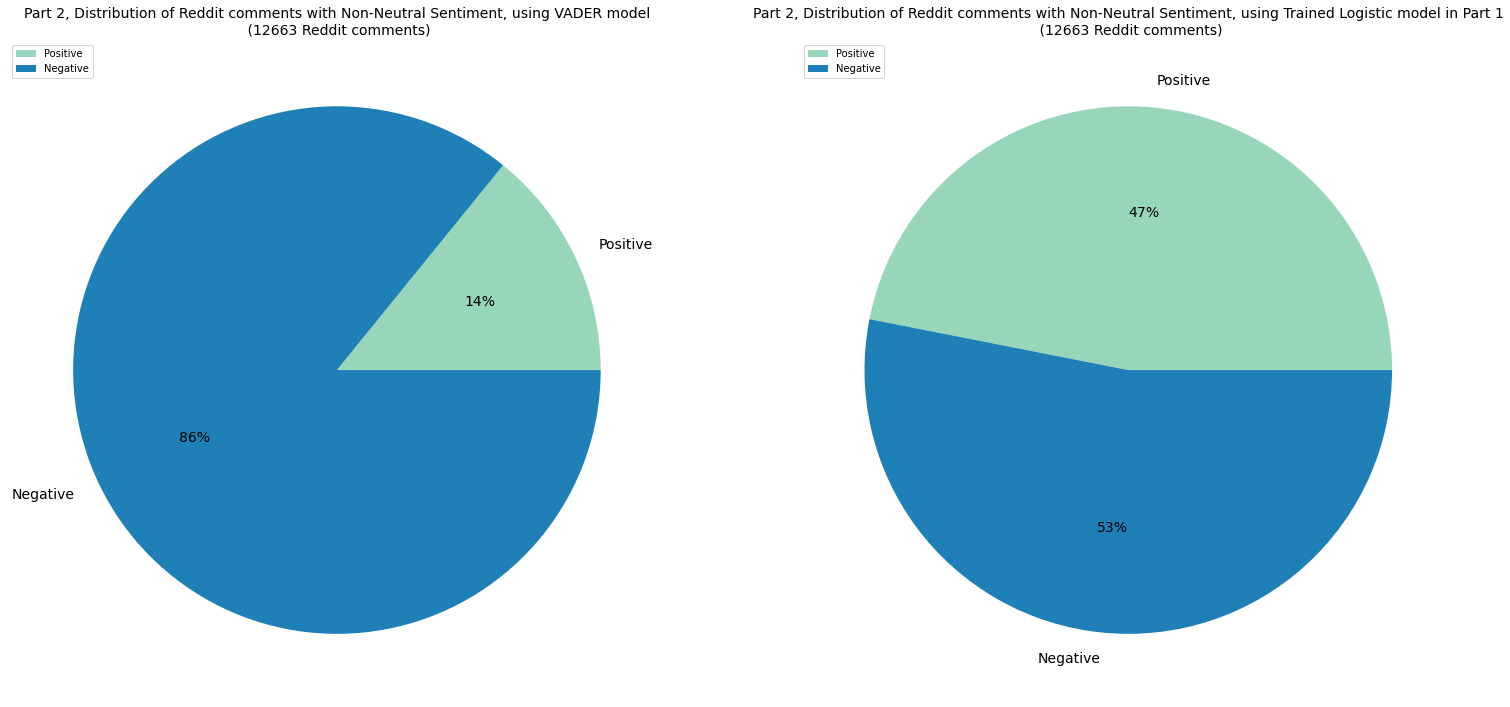

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(26, 18))
color = sns.color_palette("YlGnBu", 2)

reddit_df_non_neu_plot.plot(kind='pie', subplots=True, autopct='%.0f%%', fontsize = 14, colors = color, ax=axes[0])
axes[0].set_title('Part 2, Distribution of Reddit comments with Non-Neutral Sentiment, using VADER model\n (%s Reddit comments)'%len(reddit_df_non_neu['lr_predicted_label']), fontsize = 14)
axes[0].set_ylabel('')
axes[0].legend(loc = 'upper left')

reddit_df_non_neu_plot_vader.plot(kind='pie', subplots=True, autopct='%.0f%%', fontsize = 14, colors = color, ax=axes[1])
axes[1].set_title('Part 2, Distribution of Reddit comments with Non-Neutral Sentiment, using Trained Logistic model in Part 1\n (%s Reddit comments)'%len(reddit_df_non_neu['vadar_label']), fontsize = 14)
axes[1].set_ylabel('')
axes[1].legend(loc = 'upper left')


plt.show()

## **Part 3 Factor and topics identification via Machine Learning**

### 3.1.1 Split the dataset

In [ ]:
data_labeled = pd.read_csv("non-neutral tweets labeled using vader and lg.csv")

In [ ]:
data_labeled

,Unnamed: 0,index,language,text,hashtags,VADER Sentiment,VADER Label,p1 best model label
0,0,1,en,"online class homework , assignment exam help e...","[{'text': 'USA', 'indices': [141, 145]}, {'tex...",Positive,1,0
1,1,2,en,british intelligence ukrainerussiawar map mar ...,"[{'text': 'UkraineRussiaWar', 'indices': [21, ...",Positive,1,0
2,2,4,en,learn love prosper video ! russianwarcrimes uk...,"[{'text': 'RussianWarCrimes', 'indices': [69, ...",Positive,1,1
3,3,5,en,usa -the pentagon plan increase spending cyber...,"[{'text': 'USA', 'indices': [0, 4]}, {'text': ...",Positive,1,0
4,5,7,en,russia ’ combat loss ukrainewar front includin...,"[{'text': 'UkraineWar', 'indices': [26, 37]}, ...",Negative,0,0
...,...,...,...,...,...,...,...,...
340067,412220,184245,en,ukrainian child destined experience horror war...,"[{'text': 'Russia', 'indices': [107, 114]}, {'...",Negative,0,0
340068,412221,184247,en,"ukrainian soldier bakhmut , house house fighti...","[{'text': 'Bakhmut', 'indices': [23, 31]}, {'t...",Negative,0,0
340069,412222,184248,en,poland slovakia jointly transfer 33 mig-29 fig...,"[{'text': 'Poland', 'indices': [84, 91]}, {'te...",Positive,1,1
340070,412223,184250,en,russia syria assad ukraine zelenskywarcriminal...,"[{'text': 'Russia', 'indices': [0, 7]}, {'text...",Negative,0,0


In [ ]:
df_n = data_labeled[data_labeled["VADER Label"] == 0]
df_p = data_labeled[data_labeled["VADER Label"] == 1]

### 3.2.1 Topics for negative sentiment data

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

count_vect = CountVectorizer(stop_words='english')
doc_term_matrix = count_vect.fit_transform(df_n['text'].values.astype('U'))

In [ ]:
from sklearn.decomposition import LatentDirichletAllocation

LDA = LatentDirichletAllocation(n_components=10, random_state=8)
LDA.fit(doc_term_matrix)

LatentDirichletAllocation(random_state=8)

In [ ]:
for i,topic in enumerate(LDA.components_):
    print(f'Top 10 words for topic #{i}:')
    print([count_vect.get_feature_names_out()[i] for i in topic.argsort()[-80:]])
    print('\n')

Top 10 words for topic #0:
['shadow', 'reversed', 'oleksii', 'dec', 'miami', 'happy', 'resist', 'fewer', 'theory', 'dishonest', 'trafficked', '49оабр', '82одшбр', 'produced', 'infowars', 'uncovered', 'cough', 'cincinnati', 'airassault', '82nd', 'geopolitics', 'bend', 'basketball', 'reinforcing', '49th', 'unpunished', 'depleted', 'samuelbrownback', 'pass', 'incendiary', 'drill', 'religion', 'soldiers', 'equality', 'summit', 'russiaukraine', 'newjersey', 'lard', 'gatley', 'boston', 'imperial', 'reflecting', 'afloat', 'documented', '226', '349', 'irretrievable', '713', 'usairforce', 'rain', 'erinburnett', 'usarmy', '33', 'holodomor', 'forming', 'solider', 'trapped', 'assembly', 'band', 'barely', 'grow', 'nuremberg', 'bakhmout', '1990s', 'sitting', 'relatively', 'deployed', 'freespeech', 'equally', '165', 'severodonetsk', 'wider', 'gene', 'assemble', 'jordan', 'itv', 'militant', 'olympics', 'mullah', 'resolution']


Top 10 words for topic #1:
['accession', 'search', 'sadly', 'looming', 'de

In [ ]:
topic_values = LDA.transform(doc_term_matrix)
df_n['topics'] = topic_values.argmax(axis = 1)

<ipython-input-85-436ef6da8022>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_n['topics'] = topic_values.argmax(axis = 1)


In [ ]:
#define each topic
topics_num = {0:'air assault', 1:'united nations', 2:'destruction, shutdown', 3:'putin mass killer', 4:'crimes against humanity', 5:"insulting",
              6:'refugee, immigration', 7:'irresponsible', 8:'loss', 9:"mistreat"}
#Map the topic name 
df_n['topic name'] = df_n['topics'].map(topics_num)
df_n['topic name']

<ipython-input-86-a65cb2056ab8>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_n['topic name'] = df_n['topics'].map(topics_num)


4                   air assault
10                  air assault
13            putin mass killer
14                irresponsible
15        destruction, shutdown
                  ...          
340066     refugee, immigration
340067    destruction, shutdown
340068              air assault
340070              air assault
340071                 mistreat
Name: topic name, Length: 191104, dtype: object

### 3.2.2 Topics for positive sentiment data

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

count_vect = CountVectorizer(max_df=100, min_df=10, stop_words='english')
doc_term_matrix = count_vect.fit_transform(df_p['text'].values.astype('U'))

In [ ]:
from sklearn.decomposition import LatentDirichletAllocation

LDA = LatentDirichletAllocation(n_components=5, random_state=42)
LDA.fit(doc_term_matrix)

LatentDirichletAllocation(n_components=5, random_state=42)

In [ ]:
for i,topic in enumerate(LDA.components_):
    print(f'Top 10 words for topic #{i}:')
    print([count_vect.get_feature_names_out()[i] for i in topic.argsort()[-50:]])
    print('\n')

Top 10 words for topic #0:
['warm', 'americafirst', 'overdue', 'yuuup', 'admit', 'league', 'uber', 'sexual', 'bar', 'domestic', 'submarine', 'merman', 'თბილისი', 'საქართველო', 'karma', 'suppose', 'tractor', 'nftcommunity', 'prosecuting', 'poll', 'amid', 'sex', 'superb', 'encouraging', 'iceland', 'georgiaiseurope', 'mt', 'dmitry', 'mfa', 'wfp', 'casually', 'bashir', 'cup', 'labor', 'impetus', 'tbilisiprotests', 'guessed', 'warning', 'coat', 'incoming', 'gerashchenko_en', 'enabler', 'scrubbing', 'medvedev', 'archival', 'sexy', 'preservation', 'damaged', 'wheat', 'tesla']


Top 10 words for topic #1:
['logo', 'insolent', 'detained', 'nfl', 'surrender', 'prosecute', 'reform', 'hiphop', 'nordstream', 'm1152a1s', 'hoping', 'steel', 'adorable', 'writes', 'oryxspioenkop', 'secretsqrl123', 'treasuremembers', 'yoshi', 'jihoon', 'nowereset', 'mashiho', 'junghwan', 'hyunsuk', 'haruto', 'now_re_z', 'doyoung', 'yedam', 'jeongwoo', 'jaehyuk', 'honestly', 'asahi', 'tamimbinhamad', 'khamenei_ir', 'junk

In [ ]:
topic_values = LDA.transform(doc_term_matrix)
df_p['topics'] = topic_values.argmax(axis = 1)

<ipython-input-61-ba16c17016b5>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_p['topics'] = topic_values.argmax(axis = 1)


In [ ]:
#define each topic
topics_num = {0:'preservation', 1:'reform', 2:'weaponize', 3:'cooperate', 4:'negotiate'}
#Map the topic name 
df_p['topic name'] = df_p['topics'].map(topics_num)
df_p['topic name']

<ipython-input-62-c6f84ebf6dcf>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_p['topic name'] = df_p['topics'].map(topics_num)


0               reform
1         preservation
2            negotiate
3            negotiate
5            negotiate
              ...     
340049    preservation
340053       cooperate
340055    preservation
340061       weaponize
340069    preservation
Name: topic name, Length: 148968, dtype: object

(-0.5, 399.5, 199.5, -0.5)

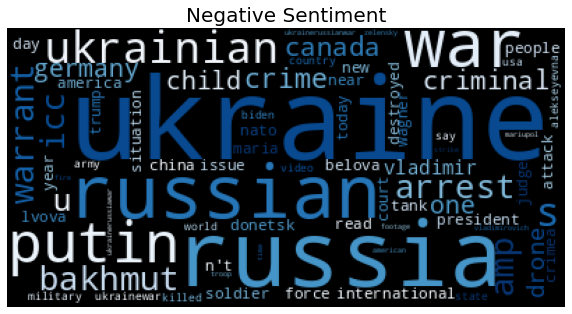

In [ ]:
# Import the wordcloud library
from wordcloud import WordCloud

# Join the different processed titles together.
long_string = ','.join(list(df_n['text'].values))

# Create a WordCloud object
wordcloud = WordCloud(collocations=False, random_state = 1, background_color="black", max_words=1000, contour_width=3, colormap='Blues_r')

# Generate a word cloud
wordcloud.generate(long_string)

# Visualize the word cloud
wordcloud.to_image()

plt.figure(figsize=(10, 10))
plt.imshow(wordcloud)
plt.title("Negative Sentiment", fontsize= 20)
plt.axis("off")

(-0.5, 399.5, 199.5, -0.5)

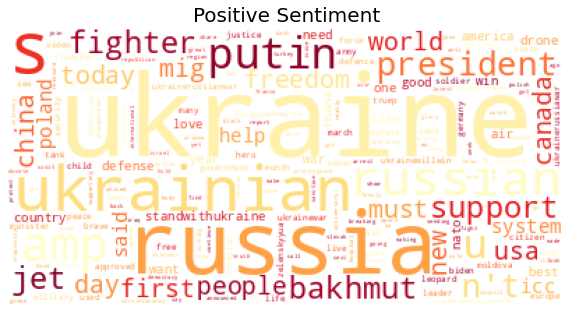

In [ ]:
# Import the wordcloud library
from wordcloud import WordCloud
s
# Join the different processed titles together.
long_string = ','.join(list(df_p['text'].values))

# Create a WordCloud object
wordcloud1 = WordCloud(collocations=False, random_state = 1, background_color="black", max_words=1000, contour_width=3, colormap = 'YlOrRd')

# Generate a word cloud
wordcloud1.generate(long_string)

# Visualize the word cloud
wordcloud1.to_image()
plt.figure(figsize=(10, 10))
plt.imshow(wordcloud1)
plt.title("Positive Sentiment", fontsize= 20)
plt.axis("off")

In [ ]:
df_n_count = pd.DataFrame(df_n['topic name'].value_counts())

In [ ]:
df_n_count

,topic name
air assault,106098
crimes against humanity,9875
united nations,9757
insulting,9605
loss,9507
putin mass killer,9497
irresponsible,9323
"destruction, shutdown",9215
"refugee, immigration",9158
mistreat,9069


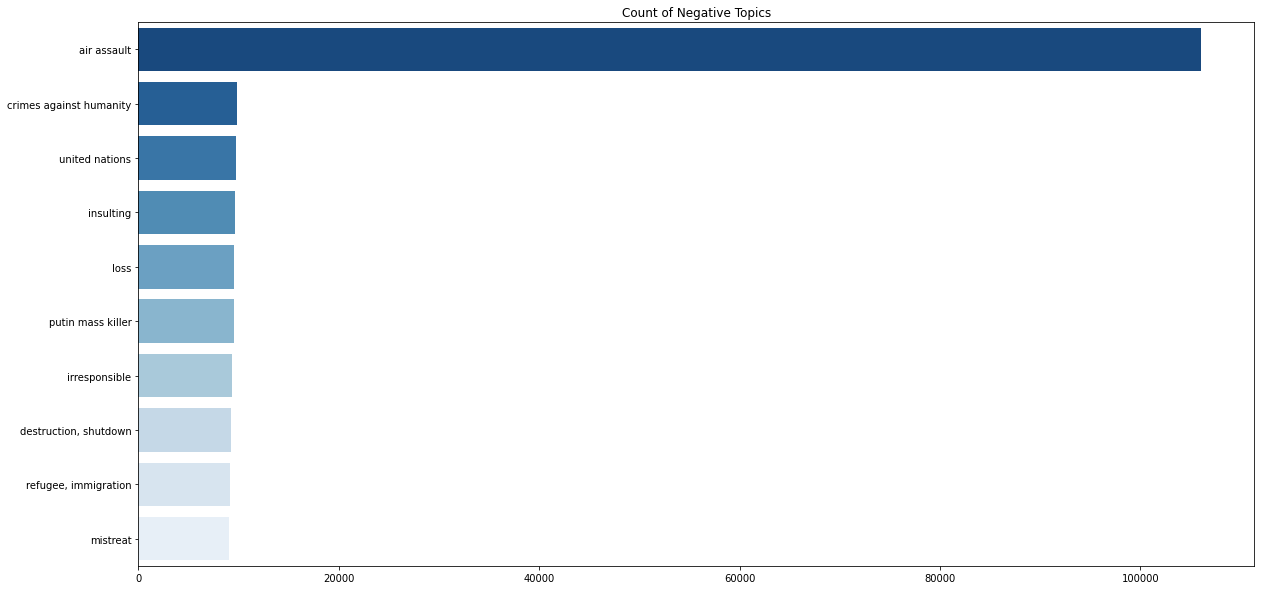

In [ ]:
import seaborn as sns
plt.figure(figsize=(20,10))
    
plot = sns.barplot(x = df_n_count.iloc[:,0].values, y = df_n_count.index.tolist(), palette="Blues_r", orient = 'h')
plot.set_title('Count of Negative Topics') 
plt.xticks(rotation='horizontal')
plt.show()

In [ ]:
df_p_count = pd.DataFrame(df_p['topic name'].value_counts())

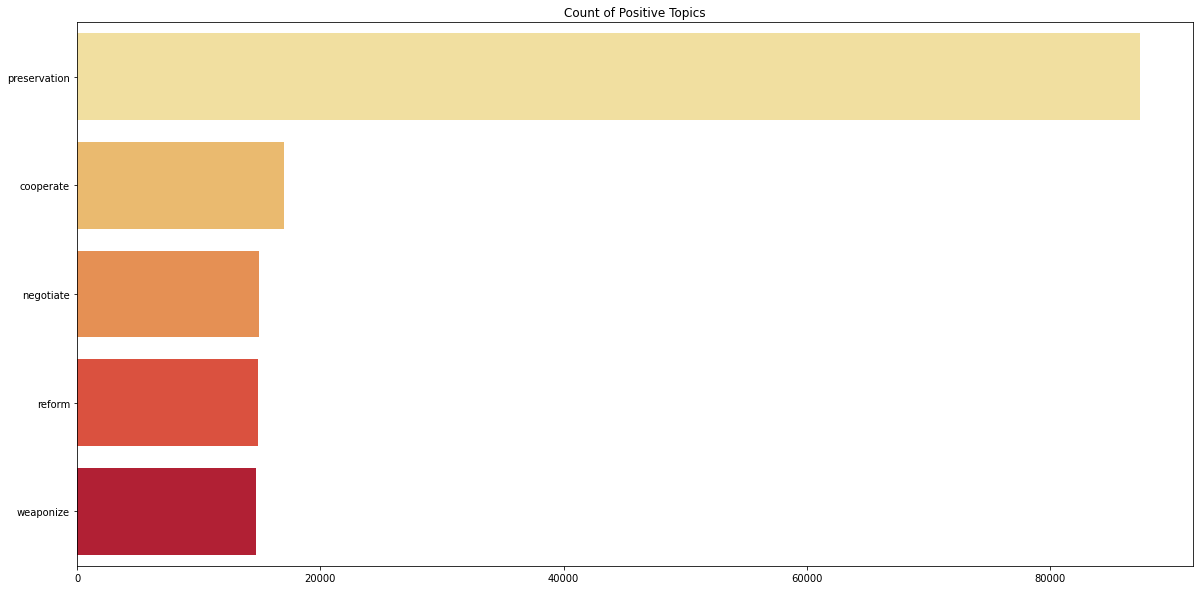

In [ ]:
import seaborn as sns
plt.figure(figsize=(20,10))
    
plot = sns.barplot(x = df_p_count.iloc[:,0].values, y = df_p_count.index.tolist(), palette="YlOrRd", orient = 'h')
plot.set_title('Count of Positive Topics') 
plt.xticks(rotation='horizontal')
plt.show()